# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import GEORGE_Library as GEORGE
%matplotlib inline

print("Done")

Done


## Define global variables

In [2]:
category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
NUM_IMAGES = None
model_directory = 'C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/'
model_name = 'non_extract_non_fill_sub_model'
model_dest = os.path.join(os.sep, model_directory, model_name)
label_id_offset = 1
score_threshold = 0.8

print("Done")

Done


# Load test images and run inference with new model!

 26%|████████████████▏                                              | 258/1001 [01:28<04:13,  2.93image/s, Subplot=6/6]


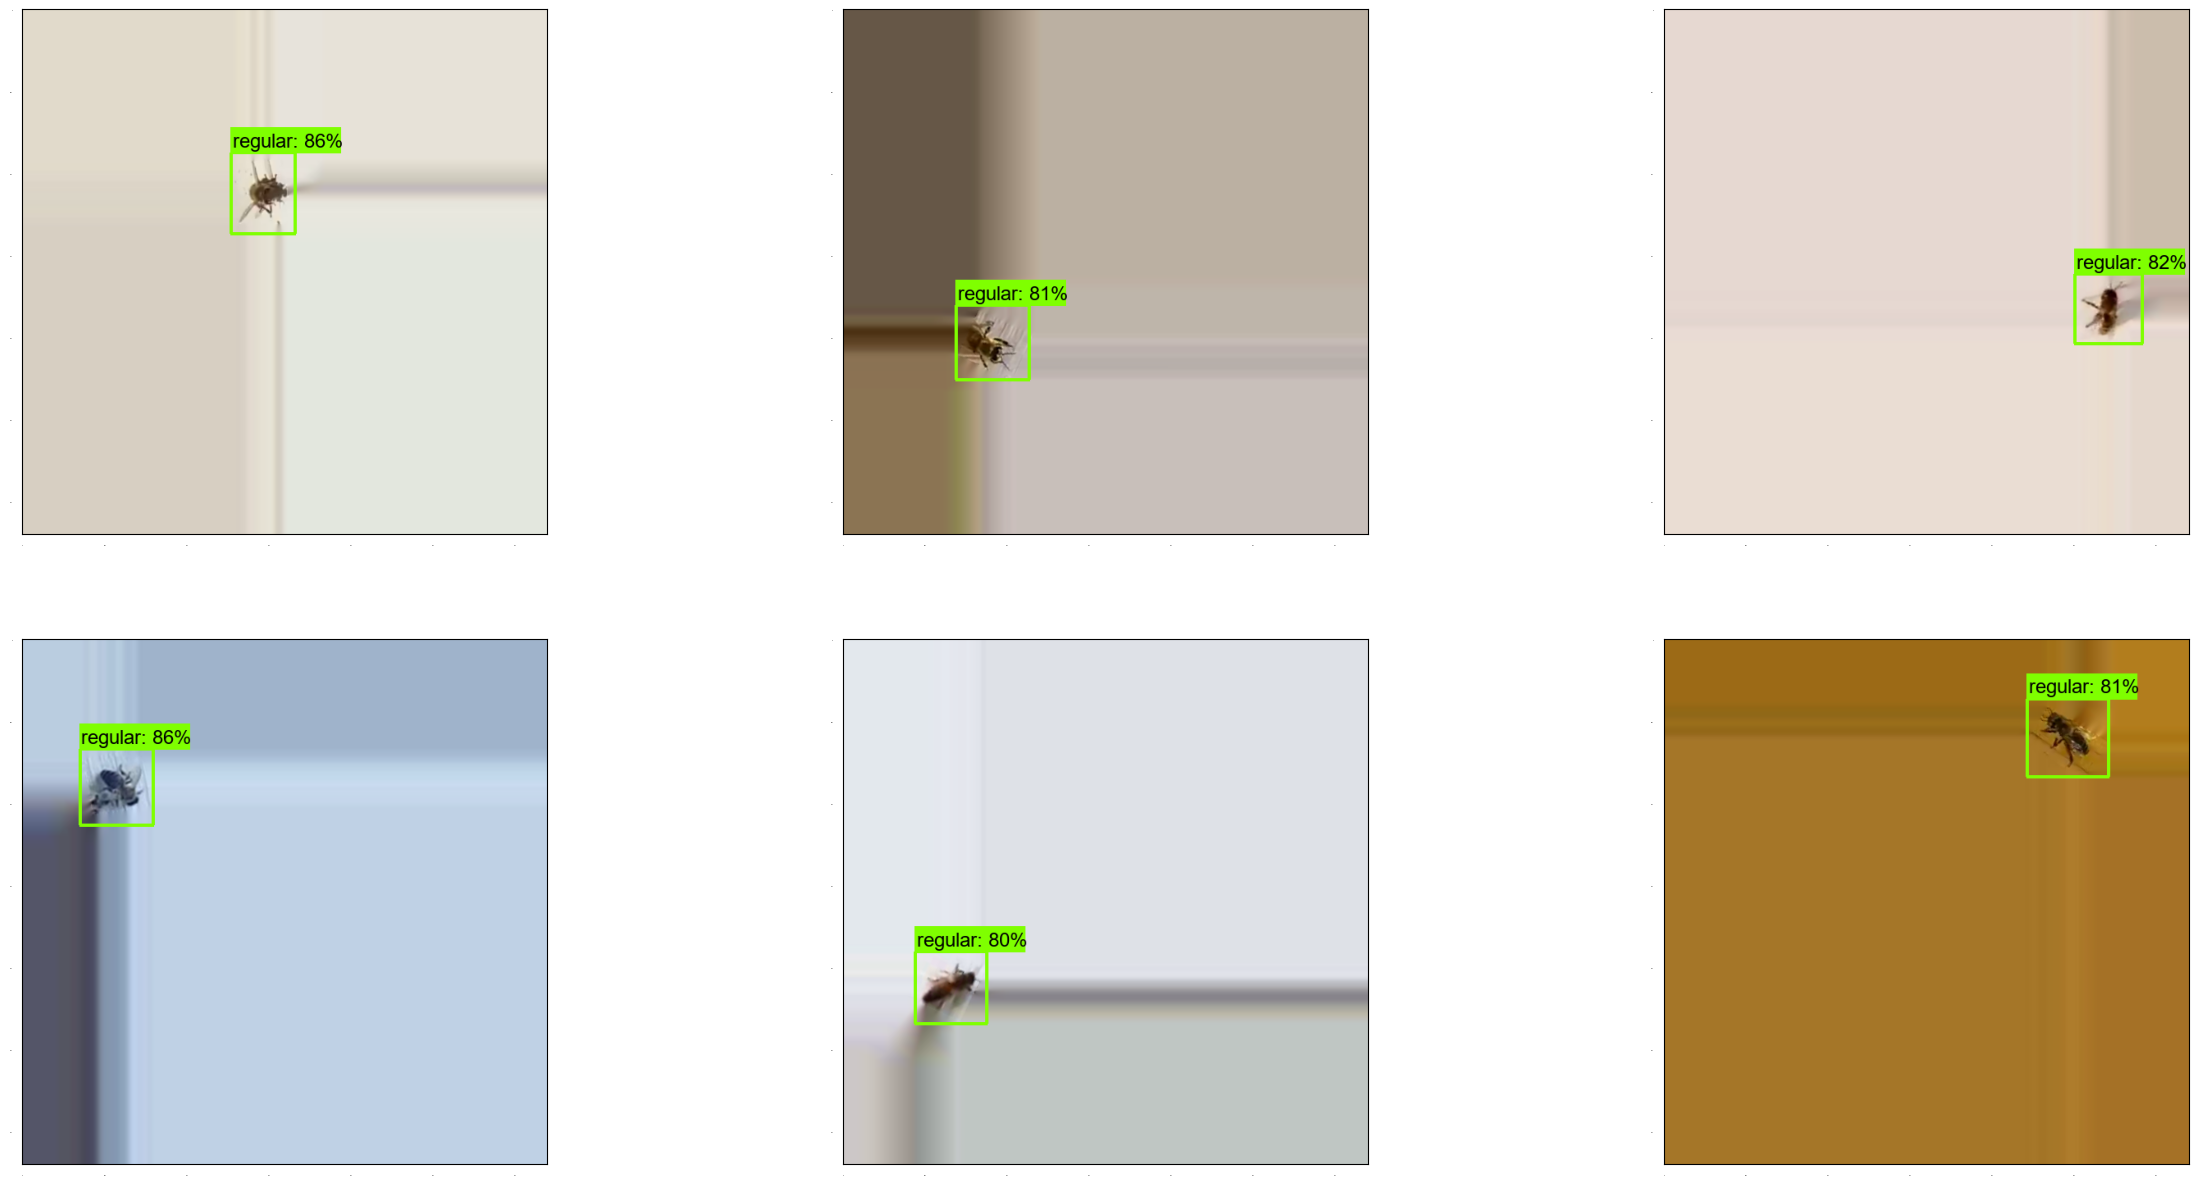

In [3]:
new_model = tf.saved_model.load(model_dest)
file_list = glob.glob(val_augmented_fp + '/*')
p = np.random.permutation(len(file_list))
val_random_file_list = [file_list[i] for i in p]

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

i = 0
j = 0

with tqdm(total = (len(val_random_file_list)), unit="image") as pbar:
    while i < 6 and j < len(val_random_file_list):
        image, label, gt_box = GEORGE.get_file_and_info(val_random_file_list[j])
        plt.subplot(2, 3, i + 1)
        input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        input_tensor = tf.expand_dims(input_tensor, 0)
        detections = new_model.signatures['detect'](input_tensor)

        if (detections['detection_scores'][0][0].numpy()) > score_threshold:
            GEORGE.plot_detections(
            image,
            np.array([detections['detection_boxes'][0][0]]),
            [(detections['detection_classes'][0][0].numpy().astype(np.uint32) + label_id_offset)],
            [(detections['detection_scores'][0][0].numpy())],
            category_index)#, figsize=(30, 15))
            i = i + 1
            j = j + 1
        else:
            j = j + 1
        pbar.set_postfix(Subplot=("%i" % i + "/%i" % 6))
        pbar.update(1)

plt.show()